# IDS.131 Preliminary Analysis
Miranda, Jinghong, Yue, Charlie, Meia

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import csv
import numpy as np
from numpy import genfromtxt


In [2]:
path = 'data/201809-bluebikes-tripdata.csv'

In [3]:
fo = open(path, "r")
lines = fo.readlines()

sept18 = []
headers = []
for header in lines[0].split(","):
    headers.append(header.strip("\"").replace(" ", "").strip("\n"))


for i, line in enumerate(lines[1:]):
    sept18.append(np.array([i.strip("\"").strip('\n') for i in line.split(",")]))
    
sept18 = np.vstack(sept18)
print(headers)
sept18

['tripduration', 'starttime', 'stoptime', 'startstationid', 'startstationname', 'startstationlatitude', 'startstationlongitude', 'endstationid', 'endstationname', 'endstationlatitude', 'endstationlongitude', 'bikeid', 'usertype', 'birthyear', 'gender"']


array([['2596', '2018-09-01 00:02:30.4810', '2018-09-01 00:45:47.0830',
        ..., 'Customer', '1969', '0'],
       ['597', '2018-09-01 00:02:45.0660', '2018-09-01 00:12:43.0080',
        ..., 'Subscriber', '1995', '1'],
       ['2497', '2018-09-01 00:02:52.2380', '2018-09-01 00:44:30.2120',
        ..., 'Customer', '1969', '0'],
       ...,
       ['808', '2018-09-30 23:59:44.3940', '2018-10-01 00:13:12.4110',
        ..., 'Subscriber', '1999', '1'],
       ['411', '2018-09-30 23:59:53.0020', '2018-10-01 00:06:44.0080',
        ..., 'Subscriber', '1982', '1'],
       ['643', '2018-09-30 19:30:33.2500', '2018-09-30 19:41:16.8290',
        ..., 'Subscriber', '1989', '2']], dtype='<U70')

In [4]:
sept18[0]

array(['2596', '2018-09-01 00:02:30.4810', '2018-09-01 00:45:47.0830',
       '67', 'MIT at Mass Ave / Amherst St', '42.3581', '-71.093198',
       '67', 'MIT at Mass Ave / Amherst St', '42.3581', '-71.093198',
       '3912', 'Customer', '1969', '0'], dtype='<U70')

In [5]:
index_map = {
    key: i for i, key in enumerate(headers)
}
index_map

{'tripduration': 0,
 'starttime': 1,
 'stoptime': 2,
 'startstationid': 3,
 'startstationname': 4,
 'startstationlatitude': 5,
 'startstationlongitude': 6,
 'endstationid': 7,
 'endstationname': 8,
 'endstationlatitude': 9,
 'endstationlongitude': 10,
 'bikeid': 11,
 'usertype': 12,
 'birthyear': 13,
 'gender"': 14}

In [6]:
station_coordinates = {
    int(row[index_map['startstationid']]): (float(row[index_map['startstationlatitude']]), float(row[index_map['endstationlatitude']])) for row in sept18
}
station_coordinates

{67: (42.3581, 42.3581),
 47: (42.362811, 42.355536284897084),
 20: (42.35991176110118, 42.35082680669095),
 66: (42.34922469338298, 42.352261),
 178: (42.35957320109044, 42.37119727759414),
 56: (42.32854046293402, 42.32854046293402),
 177: (42.36264779118595, 42.3581),
 6: (42.36129095030584, 42.353334),
 180: (42.37478628706384, 42.373231),
 33: (42.348706, 42.350406),
 61: (42.348762, 42.3581),
 89: (42.379011, 42.3722168027866),
 21: (42.34652003998412, 42.352409),
 31: (42.34881026188269, 42.3481),
 53: (42.35082680669095, 42.36346469304347),
 107: (42.3625, 42.36346469304347),
 79: (42.37842, 42.3876281075134),
 105: (42.357218503176526, 42.3581),
 100: (42.396969, 42.398365),
 45: (42.3446808403874, 42.348706),
 97: (42.36919031768079, 42.363796),
 70: (42.3722168027866, 42.380287),
 46: (42.3436658245146, 42.35082680669095),
 152: (42.345901, 42.3481),
 115: (42.387995, 42.362427842912396),
 16: (42.34807412317439, 42.310579),
 68: (42.36507, 42.37980717512428),
 23: (42.35892

In [7]:
unique_starts, count_starts = np.unique(sept18[:,3], return_counts=True)
print(*zip(unique_starts, count_starts))

('1', 28) ('10', 1532) ('100', 1403) ('102', 322) ('103', 382) ('104', 610) ('105', 2076) ('106', 55) ('107', 2851) ('108', 1088) ('109', 768) ('11', 1095) ('110', 1529) ('111', 185) ('112', 210) ('113', 517) ('114', 319) ('115', 1527) ('116', 1501) ('117', 1002) ('118', 573) ('119', 829) ('12', 1545) ('120', 1253) ('121', 843) ('122', 497) ('124', 372) ('125', 550) ('126', 142) ('128', 205) ('129', 371) ('13', 1330) ('130', 97) ('131', 698) ('133', 480) ('134', 925) ('135', 365) ('136', 585) ('137', 355) ('138', 327) ('139', 1221) ('14', 1083) ('140', 393) ('141', 820) ('142', 317) ('143', 758) ('144', 677) ('145', 336) ('146', 644) ('149', 1413) ('15', 477) ('150', 868) ('151', 1261) ('152', 1230) ('155', 395) ('156', 410) ('157', 1650) ('159', 376) ('16', 2528) ('160', 829) ('161', 1021) ('162', 69) ('163', 702) ('167', 208) ('168', 610) ('169', 404) ('17', 935) ('170', 77) ('171', 505) ('173', 185) ('174', 178) ('175', 423) ('176', 620) ('177', 2408) ('178', 3902) ('179', 3355) ('1

In [9]:
unique_ends, count_ends = np.unique(sept18[:,7], return_counts=True)
print(*zip(unique_ends, count_ends))

('1', 81) ('10', 1545) ('100', 1434) ('102', 324) ('103', 403) ('104', 579) ('105', 2142) ('106', 63) ('107', 3177) ('108', 1105) ('109', 590) ('11', 1669) ('110', 1520) ('111', 188) ('112', 212) ('113', 544) ('114', 305) ('115', 1370) ('116', 1299) ('117', 1051) ('118', 574) ('119', 811) ('12', 1571) ('120', 1248) ('121', 805) ('122', 486) ('124', 385) ('125', 535) ('126', 138) ('128', 218) ('129', 368) ('13', 1306) ('130', 81) ('131', 680) ('133', 517) ('134', 890) ('135', 366) ('136', 558) ('137', 317) ('138', 358) ('139', 1158) ('14', 1088) ('140', 402) ('141', 1677) ('142', 342) ('143', 703) ('144', 695) ('145', 339) ('146', 733) ('149', 1425) ('15', 478) ('150', 871) ('151', 1274) ('152', 1226) ('155', 382) ('156', 358) ('157', 1613) ('159', 347) ('16', 2298) ('160', 834) ('161', 948) ('162', 53) ('163', 671) ('167', 216) ('168', 633) ('169', 372) ('17', 939) ('170', 70) ('171', 452) ('173', 190) ('174', 185) ('175', 373) ('176', 683) ('177', 2323) ('178', 3860) ('179', 3257) ('1

In [ ]:
plt.plot(unique_ends, count_ends)

In [10]:
#plt.plot(unique_starts, count_starts)
unique_starts

array(['1', '10', '100', '102', '103', '104', '105', '106', '107', '108',
       '109', '11', '110', '111', '112', '113', '114', '115', '116',
       '117', '118', '119', '12', '120', '121', '122', '124', '125',
       '126', '128', '129', '13', '130', '131', '133', '134', '135',
       '136', '137', '138', '139', '14', '140', '141', '142', '143',
       '144', '145', '146', '149', '15', '150', '151', '152', '155',
       '156', '157', '159', '16', '160', '161', '162', '163', '167',
       '168', '169', '17', '170', '171', '173', '174', '175', '176',
       '177', '178', '179', '180', '181', '182', '183', '184', '185',
       '186', '187', '188', '189', '19', '190', '191', '192', '193',
       '194', '195', '196', '197', '199', '20', '200', '201', '202',
       '203', '204', '205', '206', '207', '208', '209', '21', '210',
       '211', '212', '213', '214', '215', '216', '217', '218', '219',
       '22', '220', '221', '222', '224', '225', '226', '227', '228', '23',
       '231', '232', 

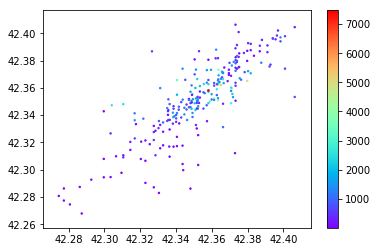

In [21]:
# Generate data...
lat = [station_coordinates[int(i)][0] for i in unique_starts]
long = [station_coordinates[int(i)][1] for i in unique_starts]

# Plot...
plt.scatter(long, lat, c=count_starts, s=2, cmap='rainbow')
plt.colorbar()

plt.show()